In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image


### Lets analyze the files

In [3]:
TRAIN_PATH='/kaggle/input/binary-biplob-art-attack/Artist Classification/train'
TEST_PATH='/kaggle/input/binary-biplob-art-attack/Artist Classification/kaggle_test'
CLASS_MAPPINGS='/kaggle/input/binary-biplob-art-attack/Artist Classification/class_mapping.yml'

In [4]:
#Printing the number of folders
os.listdir(TRAIN_PATH)

['Nycto',
 'Farjan Shahriar Abeg',
 'Teabag Stories',
 'Salman Sakib',
 'DarkaakArts',
 'Icecream Stick Art',
 'Injamamul Adittya',
 'TarTin',
 'Mahatab Rashid',
 'Zarin',
 'Inksmith',
 'Chandra Sarkar',
 'The Bathroom Artist',
 'The Panicked Architect',
 'Nishat Binte Monsur']

In [5]:
print('number of classes', len(os.listdir(TRAIN_PATH)))

number of classes 15


### The Class mappings folder contains the metadata of the dataset. When submitting, make sure you substitute each label name with its number

In [6]:
with open(CLASS_MAPPINGS) as f:
    class_mappings=f.read();

print(class_mappings)

# Class mapping for image classification dataset
# Maps class names (folder names) to numeric labels

classes:
  "Chandra Sarkar": 0
  "DarkaakArts": 1
  "Farjan Shahriar Abeg": 2
  "Icecream Stick Art": 3
  "Injamamul Adittya": 4
  "Inksmith": 5
  "Mahatab Rashid": 6
  "Nishat Binte Monsur": 7
  "Nycto": 8
  "Salman Sakib": 9
  "TarTin": 10
  "Teabag Stories": 11
  "The Bathroom Artist": 12
  "The Panicked Architect": 13
  "Zarin": 14

# Reverse mapping (numeric labels to class names)
labels:
  0: "Chandra Sarkar"
  1: "DarkaakArts"
  2: "Farjan Shahriar Abeg"
  3: "Icecream Stick Art"
  4: "Injamamul Adittya"
  5: "Inksmith"
  6: "Mahatab Rashid"
  7: "Nishat Binte Monsur"
  8: "Nycto"
  9: "Salman Sakib"
  10: "TarTin"
  11: "Teabag Stories"
  12: "The Bathroom Artist"
  13: "The Panicked Architect"
  14: "Zarin"

# Dataset metadata
num_classes: 15
dataset_name: "Artist Classification Dataset"
created_date: "2025-07-25"



### As the images are in a dataset, we use torchvision image folder to load the dataset into from a folder

In [7]:
dataset=datasets.ImageFolder('/kaggle/input/binary-biplob-art-attack/Artist Classification/train')

In [8]:
dataset.classes

['Chandra Sarkar',
 'DarkaakArts',
 'Farjan Shahriar Abeg',
 'Icecream Stick Art',
 'Injamamul Adittya',
 'Inksmith',
 'Mahatab Rashid',
 'Nishat Binte Monsur',
 'Nycto',
 'Salman Sakib',
 'TarTin',
 'Teabag Stories',
 'The Bathroom Artist',
 'The Panicked Architect',
 'Zarin']

### Splitting the Dataset

In [9]:
# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Enhanced Transforms with Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),          # Larger size for better detail
    transforms.RandomResizedCrop(224),      # Random crop for variation
    transforms.RandomHorizontalFlip(0.5),   # Horizontal flip
    transforms.RandomRotation(15),          # Slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),      # Occasional grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),             # Center crop for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Load datasets with different transforms
train_dataset_temp = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
val_dataset_temp = datasets.ImageFolder(root=TRAIN_PATH, transform=val_transform)

print(f"Classes: {train_dataset_temp.classes}")
print(f"Number of classes: {len(train_dataset_temp.classes)}")

# 4. Split indices for consistent train/val split
dataset_size = len(train_dataset_temp)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Create indices for splitting
indices = list(range(dataset_size))
np.random.seed(42)  # For reproducibility
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create datasets using SubsetRandomSampler
from torch.utils.data import Subset

train_dataset = Subset(train_dataset_temp, train_indices)
val_dataset = Subset(val_dataset_temp, val_indices)

# 5. Data loaders with better settings
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=4,      # Faster data loading
    pin_memory=True     # Better GPU transfer
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: 32")

Using device: cuda
Classes: ['Chandra Sarkar', 'DarkaakArts', 'Farjan Shahriar Abeg', 'Icecream Stick Art', 'Injamamul Adittya', 'Inksmith', 'Mahatab Rashid', 'Nishat Binte Monsur', 'Nycto', 'Salman Sakib', 'TarTin', 'Teabag Stories', 'The Bathroom Artist', 'The Panicked Architect', 'Zarin']
Number of classes: 15
Training samples: 538
Validation samples: 135
Batch size: 32


### Training Code

In [ ]:
from torchvision.models import efficientnet_b3
import torch.nn.functional as F

model = efficientnet_b3(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(train_dataset_temp.classes))
)
model = model.to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# 6. Advanced Loss & optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for better generalization
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # AdamW with weight decay

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# 7. Enhanced Training loop with early stopping
epochs = 25  # More epochs
best_val_acc = 0.0
patience = 7
patience_counter = 0

train_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training...")
for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress every 50 batches
        if batch_idx % 50 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_model.pth')
        print(f"  ✅ New best validation accuracy: {val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break
    
    print("-" * 50)

print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 195MB/s]


Model parameters: 11,490,871
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25, Batch 0/17, Loss: 2.7008
Epoch 1/25:
  Train Loss: 2.3164, Train Acc: 31.97%
  Val Loss: 1.9318, Val Acc: 42.96%
  Learning Rate: 0.001000
  ✅ New best validation accuracy: 42.96%
--------------------------------------------------
Epoch 2/25, Batch 0/17, Loss: 1.7449
Epoch 2/25:
  Train Loss: 1.6078, Train Acc: 64.87%
  Val Loss: 1.4237, Val Acc: 68.15%
  Learning Rate: 0.001000
  ✅ New best validation accuracy: 68.15%
--------------------------------------------------
Epoch 3/25, Batch 0/17, Loss: 1.3756
Epoch 3/25:
  Train Loss: 1.2528, Train Acc: 74.54%
  Val Loss: 1.2597, Val Acc: 74.81%
  Learning Rate: 0.001000
  ✅ New best validation accuracy: 74.81%
--------------------------------------------------
Epoch 4/25, Batch 0/17, Loss: 0.8853
Epoch 4/25:
  Train Loss: 1.1096, Train Acc: 80.86%
  Val Loss: 1.1631, Val Acc: 75.56%
  Learning Rate: 0.001000
  ✅ New best validation accuracy: 75.56%
--------------------------------------------------
Epoch 5/25, Batch 0/17, Loss

# Load best model

In [ ]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model with validation accuracy: {checkpoint['val_acc']:.2f}%")

# Enhanced test transform (same as validation)

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test Time Augmentation transforms
tta_transforms = [
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=1.0),  # Always flip
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.RandomRotation(degrees=5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
]

# Enhanced Custom Dataset for test folder

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, folder_path, transform=None, tta_transforms=None):
        self.folder_path = folder_path
        self.image_paths = sorted([os.path.join(folder_path, fname) 
                            for fname in os.listdir(folder_path) 
                            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform
        self.tta_transforms = tta_transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.tta_transforms:
            # Return multiple augmented versions
            images = []
            for transform in self.tta_transforms:
                images.append(transform(img))
            return images, img_path
        else:
            if self.transform:
                img = self.transform(img)
            return img, img_path

# Create dataset with TTA
test_dataset = InferenceDataset(TEST_PATH, tta_transforms=tta_transforms)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)  # Smaller batch for TTA

# Inference with Test Time Augmentation

In [ ]:
model.eval()
results = []

print("Starting inference with Test Time Augmentation...")
with torch.no_grad():
    for batch_idx, (images_list, paths) in enumerate(test_loader):
        batch_predictions = []
        
        for img_idx in range(len(paths)):
            # Get all TTA versions for this image
            tta_predictions = []
            
            for tta_idx in range(len(tta_transforms)):
                img = images_list[tta_idx][img_idx].unsqueeze(0).to(device)
                output = model(img)
                prob = torch.softmax(output, dim=1)
                tta_predictions.append(prob.cpu())
            
            # Average predictions across TTA
            avg_prediction = torch.mean(torch.stack(tta_predictions), dim=0)
            pred_class = torch.argmax(avg_prediction, dim=1).item()
            confidence = avg_prediction[0][pred_class].item()
            
            results.append({
                "image_id": os.path.basename(paths[img_idx]),
                "class_id": pred_class,
                "confidence": round(confidence, 4)
            })
        
        if batch_idx % 20 == 0:
            print(f"Processed {batch_idx * test_loader.batch_size}/{len(test_dataset)} images")

# Create submission DataFrame
df = pd.DataFrame(results)
print(f"Generated predictions for {len(df)} images")
print("\nPrediction distribution:")
print(df['class_id'].value_counts().sort_index())

# Load sample submission and create final submission
submission = pd.read_csv('/kaggle/input/binary-biplob-art-attack/sample_submission.csv')
submission['label'] = df['class_id']
submission.to_csv('submission.csv', index=False)

print(f"\n✅ Submission saved! Shape: {submission.shape}")
submission.head()

Loaded best model with validation accuracy: 82.22%
Starting inference with Test Time Augmentation...
Processed 0/882 images
Processed 160/882 images
Processed 320/882 images
Processed 480/882 images
Processed 640/882 images
Processed 800/882 images
Generated predictions for 882 images

Prediction distribution:
class_id
0      36
1      72
2      42
3     100
4      32
5      49
6      32
7      45
8      62
9      52
10     22
11    154
12     46
13     58
14     80
Name: count, dtype: int64

✅ Submission saved! Shape: (882, 2)


,ID,label
0,026uepzn.jpg,10
1,02yvvnc9.jpg,11
2,03c2jl5c.jpg,14
3,03wyn3bo.jpg,14
4,03xrzzqn.jpg,7


# Visualize training progress

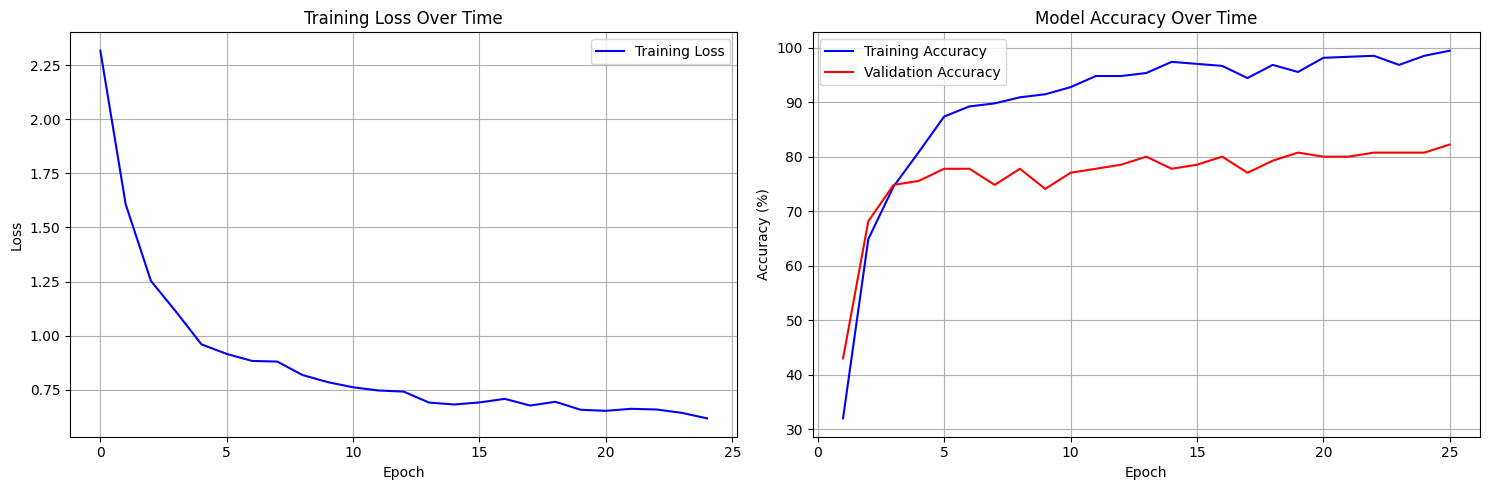

📊 Training Summary:
  - Epochs completed: 25
  - Best validation accuracy: 82.22%
  - Final training accuracy: 99.44%
  - Final validation accuracy: 82.22%


count    882.000000
mean       0.780408
std        0.204121
min        0.154400
25%        0.694100
50%        0.880850
75%        0.922700
max        0.981200
Name: confidence, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
epochs_completed = len(train_accuracies)
ax2.plot(range(1, epochs_completed + 1), train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(range(1, epochs_completed + 1), val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Model Accuracy Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final statistics
print(f"📊 Training Summary:")
print(f"  - Epochs completed: {epochs_completed}")
print(f"  - Best validation accuracy: {best_val_acc:.2f}%")
print(f"  - Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"  - Final validation accuracy: {val_accuracies[-1]:.2f}%")

# Show prediction confidence distribution
df['confidence'].describe()

# Preparing Submission file

In [13]:
submission=pd.read_csv('/kaggle/input/binary-biplob-art-attack/sample_submission.csv')

In [14]:
submission

,ID,label
0,026uepzn.jpg,1
1,02yvvnc9.jpg,1
2,03c2jl5c.jpg,1
3,03wyn3bo.jpg,1
4,03xrzzqn.jpg,1
...,...,...
877,zga2111o.jpg,1
878,zr162797.jpg,1
879,zujm17rt.jpg,1
880,zx2md9uk.jpg,1


In [15]:
df.head()

,image_id,class_id,confidence
0,026uepzn.jpg,10,0.9558
1,02yvvnc9.jpg,11,0.9299
2,03c2jl5c.jpg,14,0.9508
3,03wyn3bo.jpg,14,0.8290
4,03xrzzqn.jpg,7,0.8791


In [16]:
submission['label']=df['class_id']

In [17]:

submission.to_csv('submission.csv',index=False)